# Modelo de **Hodgkin & Huxley**

Referencias:

1. https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model
2. Eugene M. Izhikevich, Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting, Computational Neuroscience, The MIT Press (2006)
3. https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/How_to_upload_an_image_to_Colab_.ipynb#scrollTo=KKTpNAGCWLeB

## **Ejercicio 1)** Importando librerías

**a)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**b)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [ ]:
# 1.a)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [ ]:
# 1.b)
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Ejercicio 2)** Modelo de Hodgkin y Huxley

## Teoría

### Las neuronas son capacitores

Según el modelo de Hodgkin y Huxley, a primera vista las neuronas funcionan como capacitores evidenciando una diferencia de potencial eléctrico entre el exterior y el interior debido a las diferentes concentraciones de cargas iónicas que pueden existir entre estas dos regiones.
En el esquema, se utilizan agujas muy finas para inyectar una corriente iónica $i$ al interior de una neurona sumergida en una solución salina conductora.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/esquema1.png?raw=true:, width=100" alt="My Image" width=300>

Recordemos que un capacitor sujeto a una diferencia de potencial $v:=v_A-v_B$ adquiere una carga $q=cv$.
La carga crece según $\dot{q}=i$, donde $i$ denota la corriente de carga eléctrica que va desde el exterior hacia el interior.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito1.png?raw=true:, width=100" alt="My Image" width=500>

### Las neuronas son capacitores con fugas

Si miramos un poco más en detalle, veremos que la membrana de las neuronas tienen canales por donde pueden circular iones.
Podemos pensar a los canales como agujeritos en la membrana por donde la carga se fuga.
En otras palabras, podemos pensar a los canales como a una resistencia conectada en paralelo al capacitor.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito2.png?raw=true:, width=100" alt="My Image" width=500>

La corriente $i_g=g(v_A-v_B)=gv$, donde $i_g$ denota una corriente que va desde el interior hacia el exterior.

### Las neuronas son baterias

Los canales pueden ser selectivos.
Por ejemplo, algunos canales sólo dejan pasar los iones $\mathrm{K}^+$.
Por ende, si inyectamos al interior de la neurona una mezcla de iones $\mathrm{K}^+$ y $\mathrm{Cl}^-$, de manera que la carga total se encuentre equilibrada, los iónes $\mathrm{Cl}^+$ comenzarán a difundir desde el interior hacia el exterior a travéz de los canales selectivos, mientras que los de $\mathrm{Cl}^-$ se quedarán en el interior.
Esto generará un creciente excedente de cargas negativas en el interior y positivas en el exterior, hasta alcanzar un estado de equilibrio en donde la corriente de iones $\mathrm{K}^+$ provocada por la difusión se detiene debido a la diferencia de potencial emergente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/baterias.png?raw=true:, width=100" alt="My Image" width=500>

Este potencial se llama potencial de Nernst o de reversión y se lo incorpora al circuito que modela la neurona como una batería conectada en serie a la resistencia asociada a cada canal

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito3.png?raw=true:, width=100" alt="My Image" width=500>

Ahora, la corriente $i_g=g(v_A-v_C)=g(v_A-(v_B+e_g))=g(v_A-v_B-e_g)=g(v-e_g)=:g(v-v_g)$, donde en la última iguadad reconocemos la definición del potencial de Nernst $v_g$.

Si la batería se encuentra en sentido inverso

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito4.png?raw=true:, width=100" alt="My Image" width=500>

entonces $i_g=g(v_A-v_C)=g(v_A-(v_B-e_g))=g(v_A-v_B+e_g)=g(v+e_g)=:g(v-v_g)$, por lo que el potencial de Nernst resulta negativo, $v_g=-e_g$.

### Algunos canales forman reóstatos (resistencias de conductancia variable)

Algunos canales tienen compuertas que se abren o cierran, permitiendo o impidiendo el paso de iones, respectivamente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/compuertas.png?raw=true:, width=100" alt="My Image" width=500>

La conductividad asociada a estos canales, depende de la fracción de compuertas abiertas en cada tipo de canal.
Según el modelo, la conductancia total asociada a los canales de $\mathrm{Na}$ se aproxima por

$$g_{\mathrm{Na}} = \bar{g}_{\mathrm{Na}}p_{\mathrm{Na}}$$

donde $\bar{g}_{\mathrm{Na}}$ es la conductancia de $\mathrm{Na}$ máxima posible y

$$p_{\mathrm{Na}} = m^3h$$

es la fracción de canales de $\mathrm{Na}$ abiertos.
Aquí $m$ y $h$ son la fracciones de compuertas abiertas de activación e inactivación, respectivamente.
Los canales de $\mathrm{Na}$ poseen 3 compuertas de activación y 1 de inactivación, por lo que $m$ tiene un exponente 3 y $h$ un exponente 1.

De manera similar, la conductancia asociada a los canales de $\mathrm{K}$ se aproxima por

$$g_{\mathrm{K}} = \bar{g}_{\mathrm{K}}p_{\mathrm{K}}$$

donde $\bar{g}_{\mathrm{K}}$ es la conductancia de $\mathrm{K}$ máxima posible,

$$p_{\mathrm{K}} = n^4$$

es la fracción de canales de $\mathrm{K}$ abiertos y $n$ es la fracción de compuertas abiertas en este tipo de canales.
Cada canal de $\mathrm{K}$ posee 4 compuertas de tipo $n$, de ahí el exponente 4.

Estas aproximaciones asumen que las compuertas abren o cierran de manera independiente, dependiendo de la diferencia de potencial de membrana existente $v$.
Más precisamente, las fracciones de compuertas abiertas de cada tipo satisfacen

\begin{eqnarray}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h
\end{eqnarray}

donde

\begin{eqnarray}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{eqnarray}

representan las tasas a las cuales las compuertas cerradas de cada tipo abren y

\begin{eqnarray}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{eqnarray}

representan las tasas a las cuales las compuertas abiertas de cada tipo cierran, respectivamente.

En resumen, al modelo de neurona de Hodgkin y Huxley se lo puede representar por el circuito

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito5.png?raw=true:, width=100" alt="My Image" width=500>

en donde reconocemos la existencia de 3 canales iónicos: uno de pérdida (leak) de conductancia constante $g_l$, potencial de Nernst $v_l=e_l$ y por el que fluye una corriente $i_l$, uno de $\mathrm{Na}$ de conductancia variable $g_{\mathrm{Na}}$, potencial de Nernst $v_{\mathrm{Na}}=e_{\mathrm{Na}}$ y por el que fluye una corriente $i_{\mathrm{Na}}$, y uno de $\mathrm{K}$ de conductancia $g_{\mathrm{K}}$, potencial de Nernst $v_{\mathrm{K}}=-e_{\mathrm{K}}$ y por el que fluye una corriente $i_{\mathrm{K}}$.

Aplicando la ley de Kirchoff para corrientes, vemos que

$$i=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l+i_c$$

Es decir, la corriente $i$ inyectada al interior de la neurona se divide en dos partes.
Por un lado, en la corriente $i_m=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l$ que fluye a travéz de los canales en la membrana,
y por otro lado, en la corriente $i_c$ que carga el capacitor.

Remplazando, obtenemos una ODE para el potencial de membrana

\begin{eqnarray}
i_c&=&i-i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l\\
c\dot{v}&=&i-g_{\mathrm{Na}}(v-v_{\mathrm{Na}})-g_{\mathrm{K}}(v-v_{\mathrm{K}})-g_{l}(v-v_{l})\\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{eqnarray}

La última línea de la anterior ecuación, junto con las ODEs anteriormente mencionadas para $n$, $m$ y $h$, determinan el sistema de ODEs del modelo de Hodgkin y Huxley.

### Comportamiento cualitativo

Durante el proceso de disparo, diferentes compuertas se abren y cierran a diferentes tiempos.
El siguiente esquema resume el proceso en 4 etapas

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/channels.png?raw=true:, width=100" alt="My Image" width=300>

Estimaciones de los tiempos carácterísticos y valores de equilibrio del comportamiento de las compuertas observado en las diferentes etapas se pueden obtener de reescribir las ODEs para $n$, $m$ y $h$ de la forma

\begin{eqnarray}
\dot{n}&=&\tau_n^{-1}(v)(n_{\infty}(v)-n)\\
\dot{m}&=&\tau_m^{-1}(v)(m_{\infty}(v)-m)\\
\dot{h}&=&\tau_h^{-1}(v)(h_{\infty}(v)-h)
\end{eqnarray}

donde

\begin{eqnarray}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{eqnarray}

y

\begin{eqnarray}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{eqnarray}

Finalmente, listamos los valores de los parámetros del modelo (ver libro de Izhikevich)

* $c=1\,\mu F/cm^2$ : capacitancia de membrana
* $\bar{g}_{\mathrm{Na}}=120\,mS/cm^2$ : conductancia máxima de $\mathrm{Na}$
* $\bar{g}_{\mathrm{K}}=36\,mS/cm^2$ : conductancia máxima de $\mathrm{K}$
* $g_l=0.3\,mS/cm^2$ : conductancia máxima de perdida
* $v_{\mathrm{Na}}=120\,mV$ : potencial de reversión de la corriente de $\mathrm{Na}$
* $v_{\mathrm{K}}=-12\,mV$ : potencial de reversión de la corriente de $\mathrm{K}$
* $v_l=10.6\,mV$ : potencial de reversión de la corriente de perdida
* $i(t)\sim 10\,\mu A/cm^2$ : corriente de entrada al tiempo $t$
* $t \sim 5\,ms$ : tiempo

Aclaración, los valores de los potenciales de Nernst se toman en referencia al potencial de equilibrio definido en $v\approx 0\, mV$.

## Ejercicio 2) implementación

**1)** Usando la sección de teoría y las referencias, implemente el modelo de Hodgkin y Huxley el integrador numérico de ODEs tipo Runge-Kutta de orden 4 del práctico 4.

**2)** Grafique los valores de equilibrio de las distintas fracciones de canales activados $n_{\infty}$, $m_{\infty}$ e inactivados $h_{\infty}$, en función de la diferencia de potencial de membrana $v$.

**3)** Grafique los tiempos característicos de activación $\tau_m$, $\tau_n$ e inactivación $\tau_h$ asociados a los distintos tipos de canales, en función de la diferencia de potencial de membrana $v$.

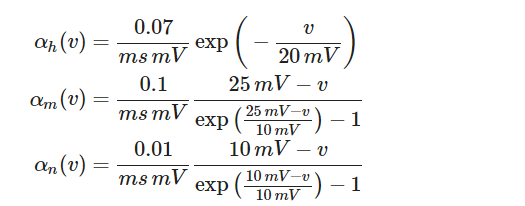

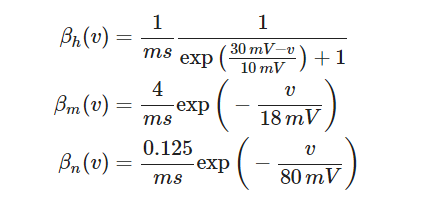

In [ ]:
# 2.1)

#Debemos definir las diferentes tasas de apertura y cierre de las compuertas:

def alpha_n(v):
    return 0.01*(10.0-v)/(np.exp((10.0-v)/10.0)-1.0)

def alpha_m(v):
    return 0.1*(25.0-v)/(np.exp((10.0-v)/10.0)-1.0)

def alpha_h(v):
    return 0.07*np.exp(-v/20.0)

def beta_h(v):
    return 1.0/(1.0+np.exp((30.0-v)/10.0))
def beta_n(v):
    return 0.125*np.exp(-v/80.0)
def beta_m(v):
    return 4.0*np.exp(-v/18.0)




def tau_n(v):
    return 1.0/(alpha_n(v)+beta_n(v))
def tau_m(v):
    return 1.0/(alpha_m(v)+beta_m(v))
def tau_h(v):
    return 1.0/(alpha_h(v)+beta_h(v))

def n_inf(v):
    return alpha_n(v)*tau_n(v)
def m_inf(v):
    return alpha_m(v)*tau_m(v)
def h_inf(v):
    return alpha_h(v)*tau_h(v)



In [ ]:
def ina(x,p):
    v = x[0]
    m = x[2]
    h = x[3]
    gna = p[1]
    vna = p[4]
    return gna*(v-vna)*m**3*4

def ik(x,p):
    v = x[0]
    n = x[1]
    gk = p[2]
    vk = p[5]
    return gk*(v-vk)*n**4

def il(x,p):
    v = x[0]
    gl = p[3]
    vl = p[6]
    return gl*(v-vl)

def f(x,t,p):
    v = x[0]
    n = x[1]
    m = x[2]
    h = x[3]
    c = p[0]
    i = p[7]
    return np.array([
        (i(t)-ina(x,p)-ik(x,p)-il(x,p))/c,     #ecuacion para dv/dt
        alpha_n(v)*(1.0-n)-beta_n(v)*n,        #ecuacion para dn/dt
        alpha_m(v)*(1.0-m)-beta_m(v)*m,        #ecuacion para dm/dt
        alpha_h(v)*(1.0-h)-beta_h(v)*h         #ecuacion para dh/dt
    ])

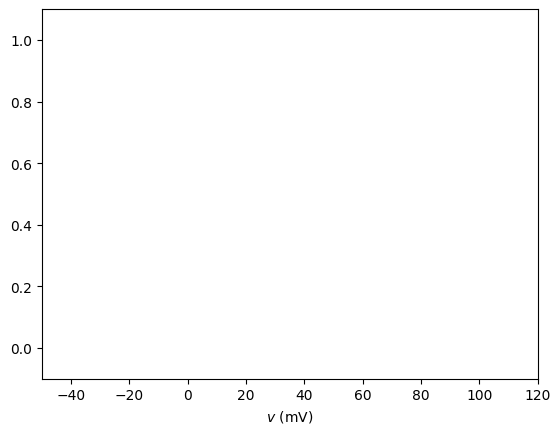

In [ ]:
plt.xlabel("$v$ (mV)")
#plt.ylabel("$x$ (dimensionless)")
plt.xlim(-50,120)
plt.ylim(-0.1,1.1)
v = np.linspace(-50,120,1000)


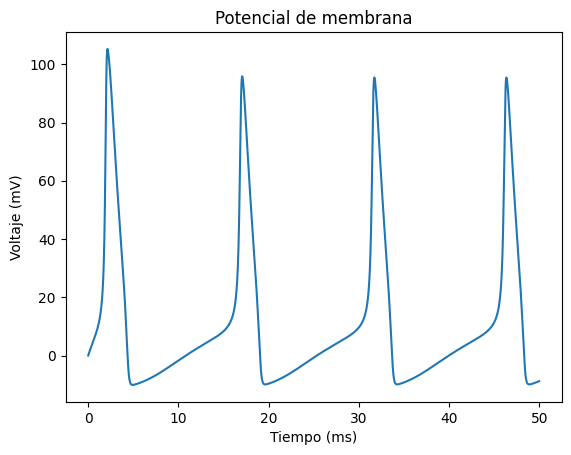

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos las funciones ya dadas
def ina(x, p):
    v = x[0]
    m = x[2]
    h = x[3]
    gna = p[1]
    vna = p[4]
    return gna * (v - vna) * m**3 * h

def ik(x, p):
    v = x[0]
    n = x[1]
    gk = p[2]
    vk = p[5]
    return gk * (v - vk) * n**4

def il(x, p):
    v = x[0]
    gl = p[3]
    vl = p[6]
    return gl * (v - vl)

def alpha_n(v):
    return 0.01 * (10.0 - v) / (np.exp((10.0 - v) / 10.0) - 1.0)

def alpha_m(v):
    return 0.1 * (25.0 - v) / (np.exp((25.0 - v) / 10.0) - 1.0)

def alpha_h(v):
    return 0.07 * np.exp(-v / 20.0)

def beta_h(v):
    return 1.0 / (1.0 + np.exp((30.0 - v) / 10.0))

def beta_n(v):
    return 0.125 * np.exp(-v / 80.0)

def beta_m(v):
    return 4.0 * np.exp(-v / 18.0)

# Valores de equilibrio n∞, m∞, h∞
def n_inf(v):
    return alpha_n(v) / (alpha_n(v) + beta_n(v))

def m_inf(v):
    return alpha_m(v) / (alpha_m(v) + beta_m(v))

def h_inf(v):
    return alpha_h(v) / (alpha_h(v) + beta_h(v))

# Definimos el modelo de Hodgkin-Huxley
def f(x, t, p):
    v = x[0]
    n = x[1]
    m = x[2]
    h = x[3]
    c = p[0]
    i_ext = p[7](t)

    # Derivadas del sistema
    dvdt = (i_ext - ina(x, p) - ik(x, p) - il(x, p)) / c
    dndt = alpha_n(v) * (1.0 - n) - beta_n(v) * n
    dmdt = alpha_m(v) * (1.0 - m) - beta_m(v) * m
    dhdt = alpha_h(v) * (1.0 - h) - beta_h(v) * h
    return np.array([dvdt, dndt, dmdt, dhdt])

# Método Runge-Kutta de 4to orden
def rk4_step(x, t, dt, f, p):
    k1 = f(x, t, p)
    k2 = f(x + 0.5 * dt * k1, t + 0.5 * dt, p)
    k3 = f(x + 0.5 * dt * k2, t + 0.5 * dt, p)
    k4 = f(x + dt * k3, t + dt, p)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Parámetros iniciales
c = 1.0  # Capacitancia
gna = 120.0  # Conductancia del canal de sodio
gk = 36.0  # Conductancia del canal de potasio
gl = 0.3  # Conductancia del canal de fuga
vna = 115.0  # Potencial de reversión del sodio
vk = -12.0  # Potencial de reversión del potasio
vl = 10.6  # Potencial de reversión del canal de fuga

p = [c, gna, gk, gl, vna, vk, vl, lambda t: 10]  # Corriente externa constante

# Condiciones iniciales
v0 = 0.0  # Potencial de membrana inicial
n0 = 0.3177  # n inicial
m0 = 0.0529  # m inicial
h0 = 0.596  # h inicial
x0 = np.array([v0, n0, m0, h0])

# Tiempo de simulación
T = 50.0  # Tiempo total
dt = 0.01  # Paso temporal
time = np.arange(0, T, dt)

# Simulación
x = x0
sol = []

for t in time:
    sol.append(x)
    x = rk4_step(x, t, dt, f, p)

sol = np.array(sol)

# Graficamos el potencial de membrana
plt.plot(time, sol[:, 0])
plt.title("Potencial de membrana")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Voltaje (mV)")
plt.show()


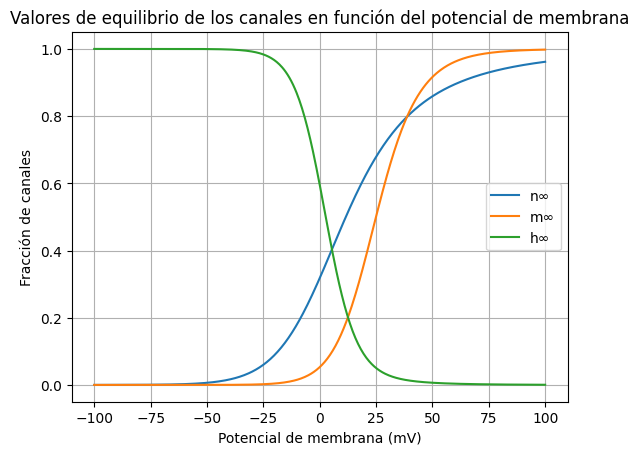

In [ ]:
# Valores de potencial de membrana para el gráfico
v_values = np.linspace(-100, 100, 500)

# Calculamos los valores de equilibrio
n_inf_values = n_inf(v_values)
m_inf_values = m_inf(v_values)
h_inf_values = h_inf(v_values)

# Graficamos los valores de equilibrio
plt.plot(v_values, n_inf_values, label='n∞')
plt.plot(v_values, m_inf_values, label='m∞')
plt.plot(v_values, h_inf_values, label='h∞')
plt.title("Valores de equilibrio de los canales en función del potencial de membrana")
plt.xlabel("Potencial de membrana (mV)")
plt.ylabel("Fracción de canales")
plt.legend()
plt.grid()
plt.show()


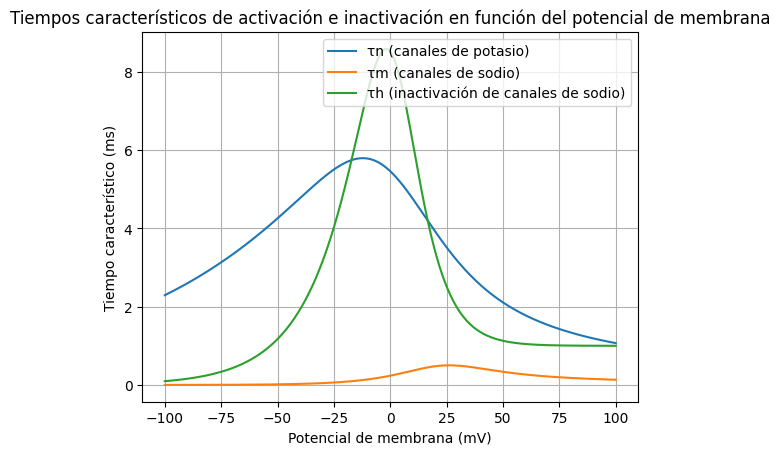

In [ ]:
#2.3
# Definimos los tiempos característicos usando las funciones definidas anteriormente
def tau_n(v):
    return 1.0 / (alpha_n(v) + beta_n(v))

def tau_m(v):
    return 1.0 / (alpha_m(v) + beta_m(v))

def tau_h(v):
    return 1.0 / (alpha_h(v) + beta_h(v))

# Valores de potencial de membrana para el gráfico
v_values = np.linspace(-100, 100, 500)

# Calculamos los tiempos característicos
tau_n_values = tau_n(v_values)
tau_m_values = tau_m(v_values)
tau_h_values = tau_h(v_values)

# Graficamos los tiempos característicos
plt.plot(v_values, tau_n_values, label='τn (canales de potasio)')
plt.plot(v_values, tau_m_values, label='τm (canales de sodio)')
plt.plot(v_values, tau_h_values, label='τh (inactivación de canales de sodio)')
plt.title("Tiempos característicos de activación e inactivación en función del potencial de membrana")
plt.xlabel("Potencial de membrana (mV)")
plt.ylabel("Tiempo característico (ms)")
plt.legend()
plt.grid()
plt.show()


## Ejercicio 3) valores de equilibrio

**1)** Integre el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a una corriente total $i(t)=0$ para todo $t$. Use la condición inicial $v_0=0mV$, $n_0=m_0=h_0=0$ y $t_0=0ms$. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

**2)** Grafique el potencial de membrana en función del tiempo, i.e. grafique $v(t)$ vs $t$ en el rango calculado.

**3)** Grafique las diferentes corrientes de iones cruzando la membrana en función del tiempo, i.e. grafique  la corriente de iones de sodio $i_{Na}(t)$, la corriente de iones de potasio $i_K(t)$ y la corriente de pérdida $i_l(t)$ vs $t$ en el rango calculado.

**4)** Grafique las fracción de canales activados e inactivados de cada tipo en función del tiempo, i.e. grafique $n(t)$ (fracción de canales de potasio $K$ activos), $m(t)$ (fracción de canales de sodio $Na$ activos) y $h(t)$ (fracción de canales de sodio $Na$ inactivos) vs $t$ en el rango calculado.

**4)** Almacene los valores de equilibrio a corriente nula de las variables dinámicas usando los valores de las mismas obtenidos a tiempos largos. Es decir, almacene los valores $v^* \approx v(t_f)$, $n^* \approx n(t_f)$, $m^* \approx m(t_f)$ y $h^* \approx h(t_f)$, para ser utilizado como condiciones iniciales en futuras integraciones de las ODEs del modelo de Hodgkin y Huxley.

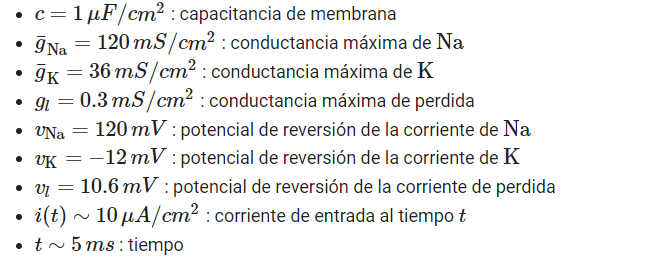

In [ ]:
# 3.1)

#Defino los parametros

c = 1.0
gna = 120.0
gk = 36.0
gl = 0.3
vna = 120.0
vk = -12.0
vl = 10.6

#Defino condiciones preliminares

v0 = 0.0
n0 = 0.0
m0 = 0.0
h0 = 0.0
x0 = np.array([v0,h0,m0,n0])

# integramos ms a la corriente i=0 para determinar el punto de equilibrio

v0 = 0.0
n0 = 0.0
m0 = 0.0
h0 = 0.0
tini = 0
tend = 500
h = 0.01
k = int((tend-tini)/h)
p = [c,gna,gk,gl,vna,vk,vl, lambda t:0]
x0 = np.array([v0,h0,m0,n0])

t,x = integrador_ode(rk4,f,x0,tini,tend,k,p)



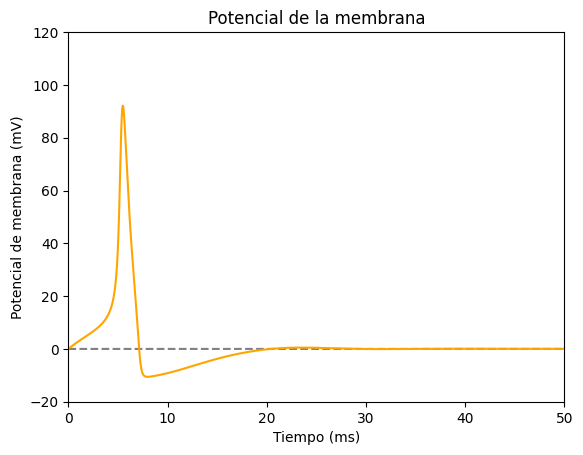

In [ ]:
#Grafico el potencial de la membrana

plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.xlim(0,50)
plt.ylim(-20,120)
plt.plot(t,0*t, linestyle="--", c="gray")
plt.plot(t,x[0], c="orange")
plt.title("Potencial de la membrana")
plt.show()

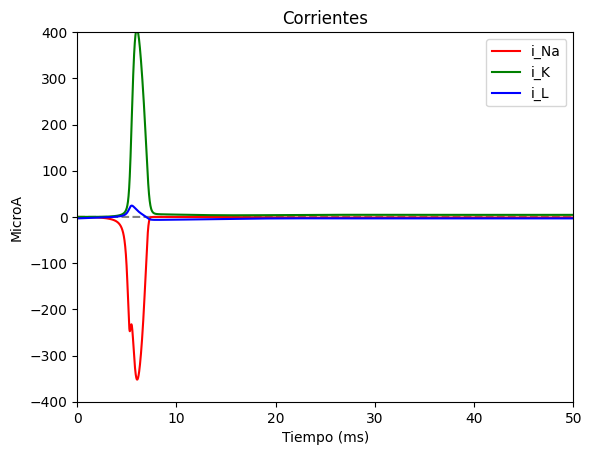

In [ ]:
#AHORA GRAFICO LAS CORRIENTES
plt.xlabel('Tiempo (ms)')
plt.ylabel('MicroA')
plt.xlim(0,50)
plt.ylim(-400,400)
plt.plot(t,0*t, linestyle="--", c="gray")
plt.plot(t, [ina(x[:,j],p) for j in range(len(t))], c="r", label="i_Na")
plt.plot(t, [ik(x[:,j],p) for j in range(len(t))], c="g", label="i_K")
plt.plot(t, [il(x[:,j],p) for j in range(len(t))], c="b", label="i_L")
plt.title("Corrientes")
plt.legend()
plt.show()


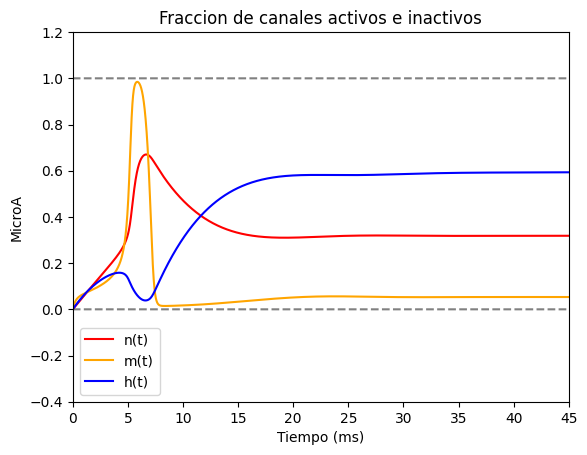

In [ ]:
#AHORA GRAFICO LAS CORRIENTES
plt.xlabel('Tiempo (ms)')
plt.ylabel('MicroA')
plt.xlim(0,45)
plt.ylim(-0.4,1.2)
plt.plot(t,0*t, linestyle="--", c="gray")
plt.plot(t,0*t+1, linestyle="--", c="gray")
plt.plot(t, x[1], label="n(t)", c="red")
plt.plot(t, x[2], label="m(t)", c="orange")
plt.plot(t, x[3], label="h(t)", c="blue")
plt.title("Fraccion de canales activos e inactivos")
plt.legend()
plt.show()

In [ ]:
#GUARDAMOS LOS VALORES DE EQUILIBRIO PARA UTILIZAR COMO CONDICIONES INICIALES EN LOS SIGUIENTES EXPERIMENTOS

x0=x[:,-1]

## Ejercicio 4) estímulo débil y estímulo fuerte

**1)** Implemente una función de corriente de entrada o membrana dada por:

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [2ms,2.5ms] \\
30 \mu A/cm^2, & t\in [10ms,10.5ms] \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Aquí, $c.c.$ indica *en caso contrario*. Esta corriente representa un estímulo débil seguido de uno fuerte. Grafíque la corriente $i(t)$ vs $t$ en el rango $t\in[0ms,20ms]$.

**2)** Integre nuevamente el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a la corriente del inciso anterior. Use como condición inicial a tiempo $t=0$ los valores de equilibrio estimados en el ejercicio anterior. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

**3)** Grafique el potencial de membrana en función del tiempo, i.e. $v(t)$ vs $t$ en el rango calculado.

**4)** Grafique la evolución de las fraciones de canales activos e inactivos, $n(t)$, $m(t)$ y $h(t)$ vs $t$.

**5)** Discuta como responde la neurona en el primer impulso a $t=2ms$. Luego, como responde al segundo impulso a $t=10ms$. Existe una diferencia? Explique.


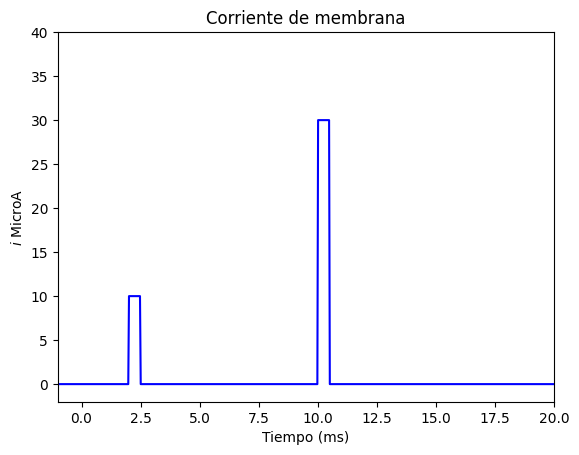

In [ ]:
# 4.1)

#DEFINIMOS LA FUNCION CORRIENTE I(T)

def i(t):
    if t>=2.0 and t<=2.5:
        return 10.0
    elif t>=10.0 and t<=10.5:
        return 30.0
    else:
        return 0.0


#Grafico la corriente de la membrana

plt.xlabel('Tiempo (ms)')
plt.ylabel("$i$ MicroA")
plt.xlim(-1,20)
plt.ylim(-2,40)
t = np.linspace(-1,30,1000)
plt.plot(t, [i(t0) for t0 in t], c="b")
plt.title("Corriente de membrana")
plt.show()


In [ ]:
# Parámetros iniciales
#tini = 0   # Tiempo inicial
#tend = 20  # Tiempo final
#h = 0.01   # Paso temporal
#k = int((tend - tini) / h)  # Cantidad de pasos

# Parámetros del sistema
#p = [c, gna, gk, gl, vna, vk, vl, i]  # Lista de parámetros

# Llamada al integrador ODE (asumiendo que integrador_ode está definido)
#t, x = integrador_ode(rk4, f, x0, tini, tend, k, p)


In [ ]:
#4.2

tini = 0
tend = 20
h = 0.01
k = int((tend-tini)/h)
p = [c,gna,gk,gl,vna,vk,vl, i]

t,x = integrador_ode(rk4, f, x0, tini, tend, k, p)


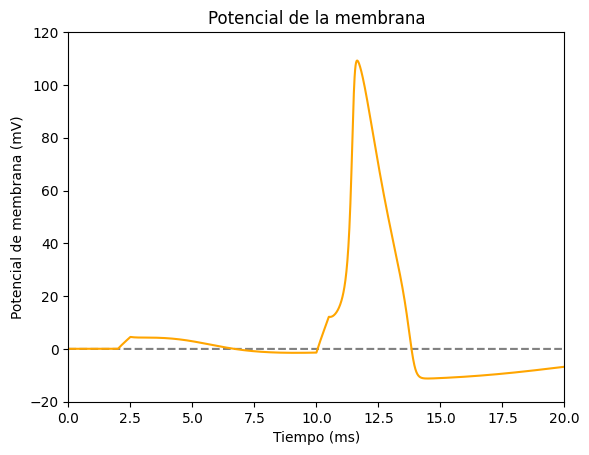

In [ ]:
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.xlim(0,20)
plt.ylim(-20,120)
plt.plot(t,0*t, linestyle="--", c="gray")
plt.plot(t,x[0], c="orange")
plt.title("Potencial de la membrana")
plt.show()

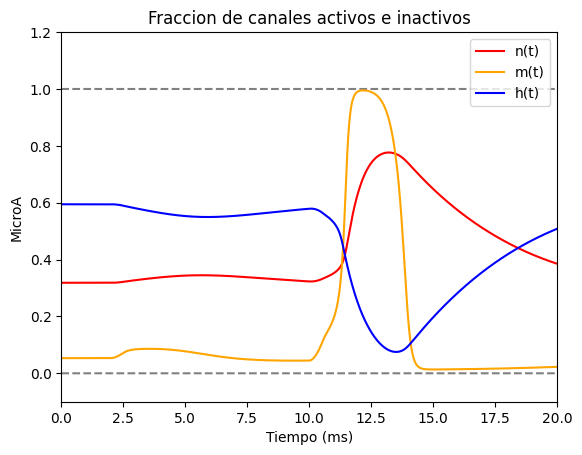

In [ ]:
#AHORA GRAFICO LAS COMPUERTAS
plt.xlabel('Tiempo (ms)')
plt.ylabel('MicroA')
plt.xlim(0,20)
plt.ylim(-0.1,1.2)
plt.plot(t,0*t, linestyle="--", c="gray")
plt.plot(t,0*t+1, linestyle="--", c="gray")
plt.plot(t, x[1], label="n(t)", c="red")
plt.plot(t, x[2], label="m(t)", c="orange")
plt.plot(t, x[3], label="h(t)", c="blue")
plt.title("Fraccion de canales activos e inactivos")
plt.legend()
plt.show()

## Ejercicio 5) ráfaga

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [5ms,\infty ms) \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Esta corriente representa un estímulo constante.

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando como condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [ ]:
# 5.1)

def i(t):
    if t>=5.0:
        return 10.0
    else:
        return 0.0


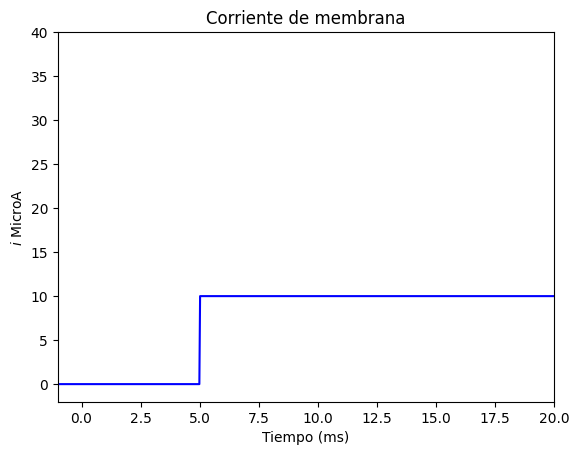

In [ ]:
plt.xlabel('Tiempo (ms)')
plt.ylabel("$i$ MicroA")
plt.xlim(-1,20)
plt.ylim(-2,40)
t = np.linspace(-1,30,1000)
plt.plot(t, np.vectorize(i)(t), c="b")
plt.title("Corriente de membrana")
plt.show()

In [ ]:
#A partir de los 5 milisegundos se le pasa una corriente alta, y vemos como reacciona la membrana

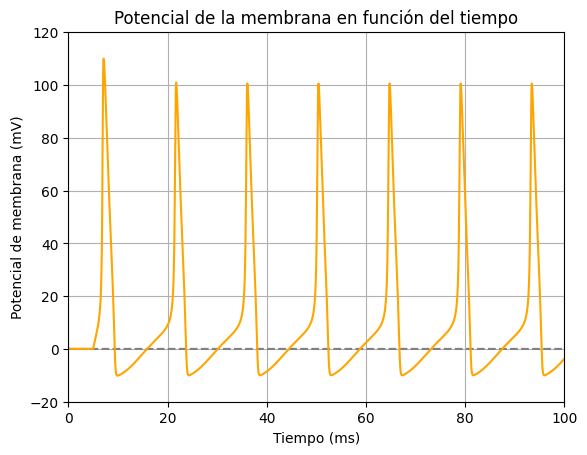

In [ ]:
# Modelo #5.1
def i(t):
    if t >= 5.0:
        return 10.0
    else:
        return 0.0


# Condiciones iniciales y parámetros
tini = 0   # Tiempo inicial
tend = 100  # Tiempo final (100 ms)
h = 0.01   # Paso temporal
k = int((tend - tini) / h)  # Cantidad de pasos

# Parámetros del sistema (ya definidos previamente)
p = [c, gna, gk, gl, vna, vk, vl, i]

# Llamada al integrador ODE (asumiendo que integrador_ode está definido)
t, x = integrador_ode(rk4, f, x0, tini, tend, k, p)


# Gráfico del potencial de membrana v(t)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.xlim(0, 100)
plt.ylim(-20, 120)
plt.plot(t, 0 * t, linestyle="--", c="gray")
plt.plot(t, x[0], c="orange")
plt.title("Potencial de la membrana en función del tiempo")
plt.grid()
plt.show()


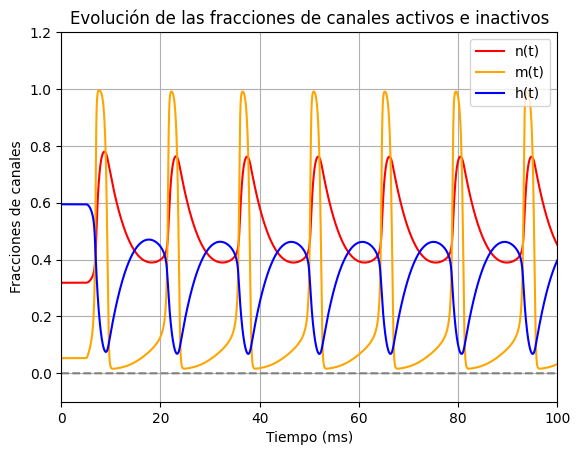

In [ ]:
# Gráfico de fracciones de canales activos e inactivos
plt.xlabel('Tiempo (ms)')
plt.ylabel('Fracciones de canales')
plt.xlim(0, 100)
plt.ylim(-0.1, 1.2)
plt.plot(t, 0 * t, linestyle="--", c="gray")
plt.plot(t, x[1], label="n(t)", c="red")     # Fracción de canales de K activados
plt.plot(t, x[2], label="m(t)", c="orange")  # Fracción de canales de Na activados
plt.plot(t, x[3], label="h(t)", c="blue")    # Fracción de canales de Na inactivados
plt.title("Evolución de las fracciones de canales activos e inactivos")
plt.legend()
plt.grid()
plt.show()


## Ejercicio 6) período refractario

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [10ms\, k,10 ms\, k + 2ms], k \in \{1,2,3,4,5,...\}\\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando la corriente del inciso **12)**, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

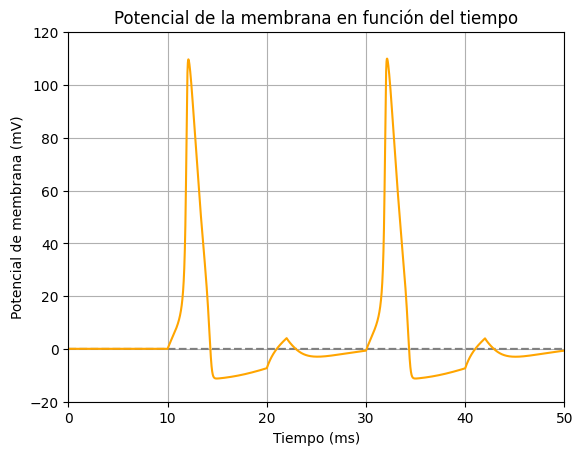

In [ ]:
# 6.1)

def i(t):
    for n in range(1,10):
        if t>=10.0*n and t<=10.0*n+2.0:
            return 10.0
    return 0.0


# Condiciones iniciales y parámetros
tini = 0   # Tiempo inicial
tend = 50  # Tiempo final (100 ms)
h = 0.01   # Paso temporal
k = int((tend - tini) / h)  # Cantidad de pasos

# Parámetros del sistema
p = [c, gna, gk, gl, vna, vk, vl, i]

# Llamada al integrador ODE (asumiendo que integrador_ode está definido)
t, x = integrador_ode(rk4, f, x0, tini, tend, k, p)

# Gráfico del potencial de membrana v(t)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.xlim(0, 50)
plt.ylim(-20, 120)
plt.plot(t, 0 * t, linestyle="--", c="gray")
plt.plot(t, x[0], c="orange")
plt.title("Potencial de la membrana en función del tiempo")
plt.grid()
plt.show()


Periodo refractario es el segundo periodo en el cual la neurona no dispara

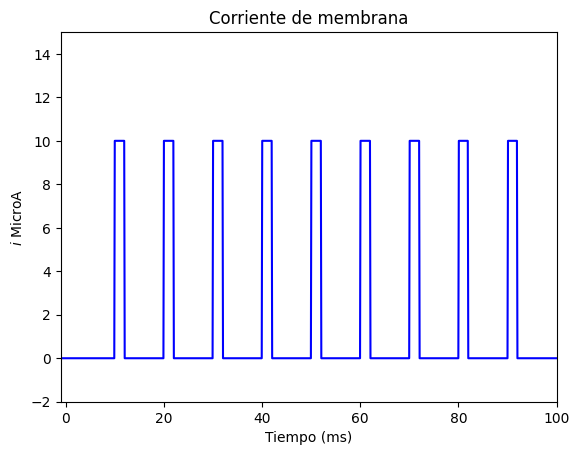

In [ ]:
plt.xlabel('Tiempo (ms)')
plt.ylabel("$i$ MicroA")
plt.xlim(-1,100)
plt.ylim(-2,15)
t = np.linspace(-1,100,1000)
plt.plot(t, np.vectorize(i)(t), c="b")
plt.title("Corriente de membrana")
plt.show()

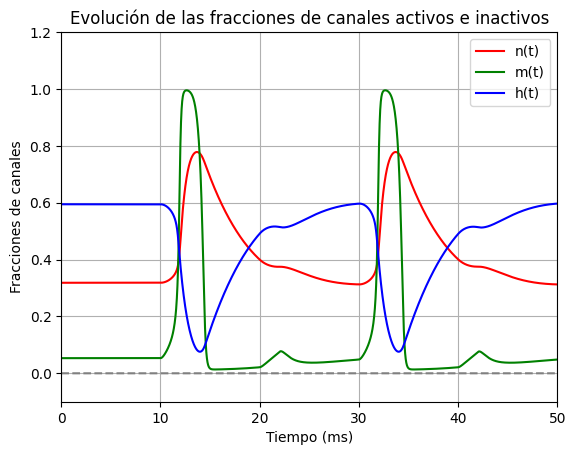

In [ ]:
# Gráfico de fracciones de canales activos e inactivos
plt.xlabel('Tiempo (ms)')
plt.ylabel('Fracciones de canales')
plt.xlim(0, 50)
plt.ylim(-0.1, 1.2)
plt.plot(t, 0 * t, linestyle="--", c="gray")
plt.plot(t, x[1], label="n(t)", c="red")     # Fracción de canales de K activados
plt.plot(t, x[2], label="m(t)", c="green")  # Fracción de canales de Na activados
plt.plot(t, x[3], label="h(t)", c="blue")    # Fracción de canales de Na inactivados
plt.title("Evolución de las fracciones de canales activos e inactivos")
plt.legend()
plt.grid()
plt.show()


## Ejercicio 7) exitaciones espontáneas en respuesta al ruido

**1)** Implemente una corriente estocástica que retorne un valor $i(t)\sim i_0 N(0,1)$ (i.e. $i_0$ por un valor aleatorio obtenido de una distribución normal de media 0 y varianza 1) para cada valor de $t$ en el que sea evaluada.

**2)** Integre nuevamente las ODEs para $t\in[0ms,500ms]$, usando la corriente del inciso **22)** para $i_0=50\mu A$, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Observa picos de activación cada tanto? Aparecen con regularidad? Estime con que frecuencia observa los picos.

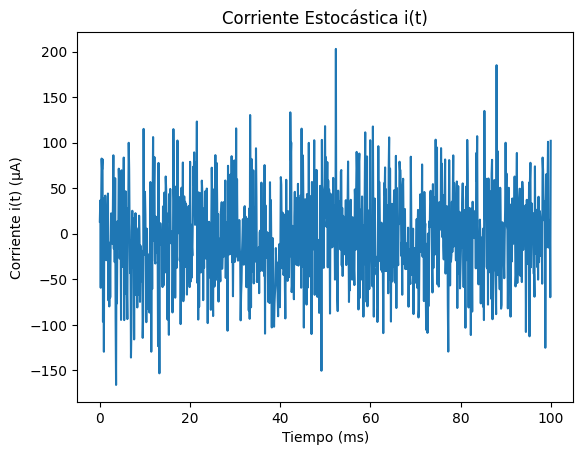

In [ ]:
# 7.1)
import numpy as np

# Definir la amplitud de la corriente
i0 = 50.0  # Valor de i0 punto 2

# Definir la función de corriente estocástica
def i(t):
    return i0 * np.random.normal(0, 1)

# Prueba la función para un rango de tiempo
t_vals = np.linspace(0, 100, 1000)  # Tiempo en ms
i_vals = [i(t) for t in t_vals]     # Valores de corriente estocástica

# Graficar los valores de corriente
import matplotlib.pyplot as plt
plt.plot(t_vals, i_vals)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Corriente i(t) (µA)')
plt.title('Corriente Estocástica i(t)')

plt.show()


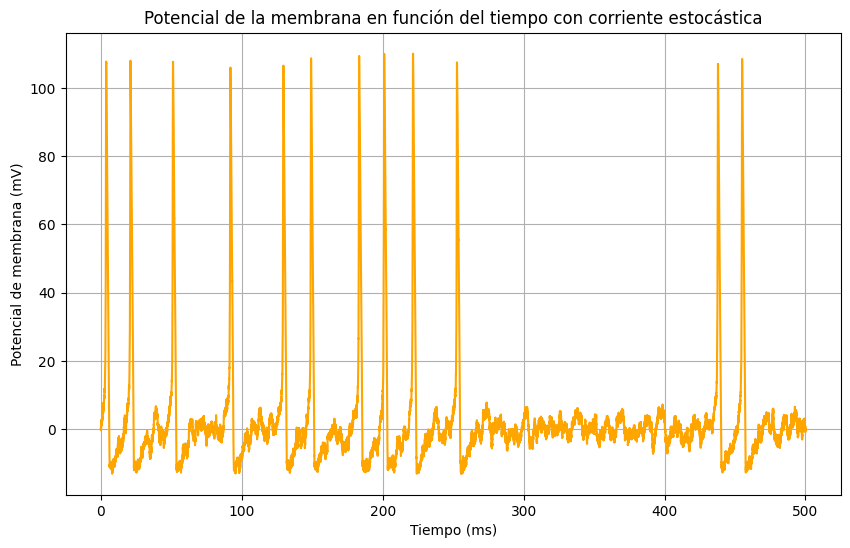

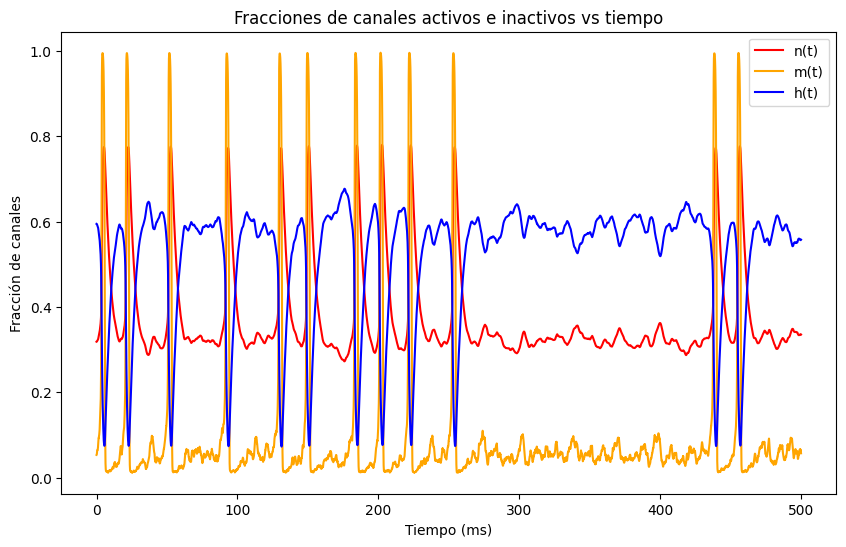

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la corriente estocástica con i0=50µA
i0 = 50.0  # µA

# Definir la función de corriente estocástica
def i(t):
    return i0 * np.random.normal(0, 1)

# Parámetros del sistema
tini = 0       # Tiempo inicial
tend = 500     # Tiempo final (500 ms)
h = 0.01       # Paso temporal
k = int((tend - tini) / h)  # Cantidad de pasos

# Condiciones iniciales (supuestas del inciso 6, valores de equilibrio)


# Parámetros p (incluyen la función de corriente estocástica)
p = [c, gna, gk, gl, vna, vk, vl, i]

# Integramos el sistema con la función de corriente estocástica
t, x = integrador_ode(rk4, f, x0, tini, tend, k, p)

# 3. Gráfico del potencial de membrana v(t)
plt.figure(figsize=(10, 6))
plt.plot(t, x[0], c="orange")
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title("Potencial de la membrana en función del tiempo con corriente estocástica")
plt.grid(True)
plt.show()

# 4. Gráfico de las fracciones de canales activos e inactivos n(t), m(t), h(t)
plt.figure(figsize=(10, 6))
plt.plot(t, x[1], label="n(t)", c="red")     # Fracción de canales de K activados
plt.plot(t, x[2], label="m(t)", c="orange")  # Fracción de canales de Na activados
plt.plot(t, x[3], label="h(t)", c="blue")    # Fracción de canales de Na inactivados
plt.xlabel('Tiempo (ms)')
plt.ylabel('Fracción de canales')
plt.title("Fracciones de canales activos e inactivos vs tiempo")
plt.legend()
plt.show()

# 5. Análisis de los picos de activación
# Se puede hacer un análisis visual o también identificar picos de v(t) programáticamente.


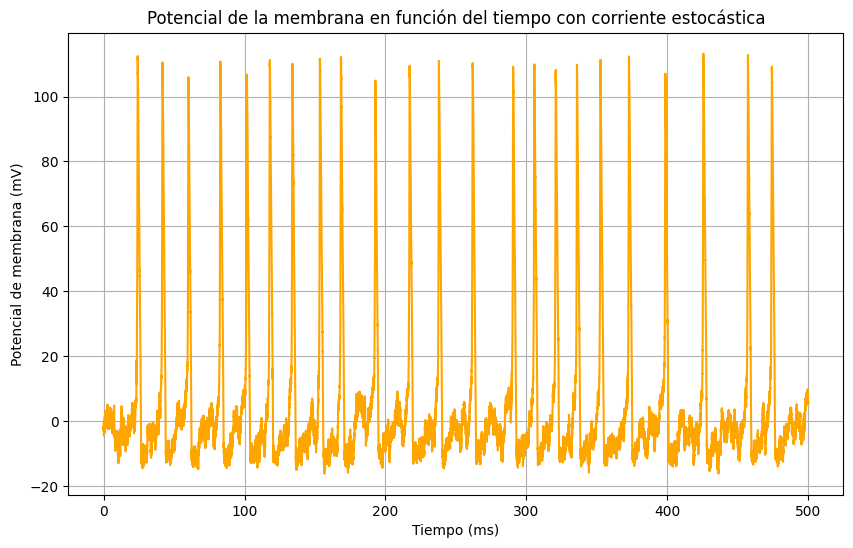

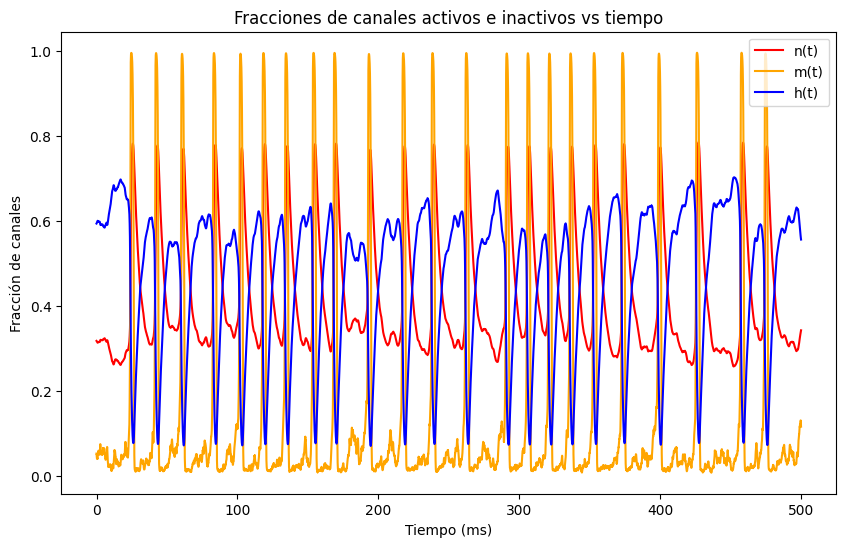

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Definir la corriente estocástica con i0=50µA
i0 = 50.0  # µA

# Definir la función de corriente estocástica
def i(t):
    return i0 * np.random.normal(0, 1)

# Parámetros del sistema
tini = 0       # Tiempo inicial
tend = 500     # Tiempo final (500 ms)
h = 0.01       # Paso temporal
k = int((tend - tini) / h)  # Cantidad de pasos

# Condiciones iniciales (supuestas del inciso 6, valores de equilibrio)


# Parámetros p (incluyen la función de corriente estocástica)
p = [c, gna, gk, gl, vna, vk, vl, i]

# Integramos el sistema con la función de corriente estocástica
t, x = integrador_ode(euler, f, x0, tini, tend, k, p)

# 3. Gráfico del potencial de membrana v(t)
plt.figure(figsize=(10, 6))
plt.plot(t, x[0], c="orange")
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title("Potencial de la membrana en función del tiempo con corriente estocástica")
plt.grid(True)
plt.show()

# 4. Gráfico de las fracciones de canales activos e inactivos n(t), m(t), h(t)
plt.figure(figsize=(10, 6))
plt.plot(t, x[1], label="n(t)", c="red")     # Fracción de canales de K activados
plt.plot(t, x[2], label="m(t)", c="orange")  # Fracción de canales de Na activados
plt.plot(t, x[3], label="h(t)", c="blue")    # Fracción de canales de Na inactivados
plt.xlabel('Tiempo (ms)')
plt.ylabel('Fracción de canales')
plt.title("Fracciones de canales activos e inactivos vs tiempo")
plt.legend()
plt.show()